# Разведочный анализ данных

## Описание

Основная задача проекта – выявить ключевые темы обсуждений у 18 активных чатов и каналов выпускных сообществ Яндекс Практикума, определить, какие из них наиболее интересны аудитории, и на основе этого формировать информативные дайджесты для выпускников.

**Контекст**

- необходимо провести первичный анализ сообщений,

**Что нужно сделать?**

1. кто пишет часто
2. в какое время чаще всего пишут пользователи
3. сколько пишут сообщений сколько
4. анализ времени → пики активности, дни недели.
5. подумать, что можно еще посчитать полезного

**Результат:**

- код .py, .ipynb
- csv/xlsx файл со статистикой

## Библиотеки

In [67]:
import logging
import os
import warnings

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import shap
from scipy import stats
from scipy.optimize import minimize
from scipy.stats import mstats
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.statespace.sarimax import SARIMAX
import ast
from wordcloud import WordCloud
from collections import Counter

# Настройка параметров matplotlib
mpl.rcParams.update(mpl.rcParamsDefault)

# Настройка логирования
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger(__name__)

# Игнорирование предупреждений
warnings.filterwarnings('ignore')

# Настройка стиля seaborn
sns.set_context("notebook", font_scale=1.2)
sns.set_style("whitegrid")

# Включение отображения графиков в Jupyter Notebook
%matplotlib inline

## Загрузка датасетов

In [68]:
df = pd.read_csv('..\def_Klyusnik_A\output\processed_messages.csv')
df_1 = pd.read_csv('..\def_Klyusnik_A\output\processed_messages_1.csv')

print('Загрузка df:', df.shape, 'загрузка df_1:', df_1.shape)

Загрузка df: (13, 18) загрузка df_1: (1007, 36)


## Df Первый датасет представленный заказчиком

In [69]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13 entries, 0 to 12
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             13 non-null     object 
 1   type             13 non-null     object 
 2   id_first         13 non-null     int64  
 3   id               13 non-null     int64  
 4   type.1           13 non-null     object 
 5   date             13 non-null     object 
 6   date_unixtime    13 non-null     int64  
 7   edited           13 non-null     object 
 8   edited_unixtime  13 non-null     int64  
 9   from             13 non-null     object 
 10  from_id          13 non-null     object 
 11  text             13 non-null     object 
 12  text_entities    13 non-null     object 
 13  reactions        13 non-null     object 
 14  photo            9 non-null      object 
 15  photo_file_size  9 non-null      float64
 16  width            9 non-null      float64
 17  height           9

In [70]:
df.head(5)

,name,type,id_first,id,type.1,date,date_unixtime,edited,edited_unixtime,from,from_id,text,text_entities,reactions,photo,photo_file_size,width,height
0,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,856,message,2025-02-01T14:06:16,1738407976,2025-02-01T14:07:41,1738408061,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': '💥'}, {'type': 'bold...","[{'type': 'bold', 'text': '💥'}, {'type': 'bold...","[{'type': 'emoji', 'count': 6, 'emoji': '👍'}, ...",NaN,NaN,NaN,NaN
1,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,857,message,2025-02-02T14:07:55,1738494475,2025-02-03T13:05:36,1738577136,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': '💭 Переговорный клуб...","[{'type': 'bold', 'text': '💭 Переговорный клуб...","[{'type': 'emoji', 'count': 8, 'emoji': '🔥'}, ...",photos/photo_368@02-02-2025_14-07-55.jpg,130046.0,1280.0,1280.0
2,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,858,message,2025-02-03T14:04:43,1738580683,2025-02-03T14:10:35,1738581035,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': 'У Практикума новый ...","[{'type': 'bold', 'text': 'У Практикума новый ...","[{'type': 'emoji', 'count': 11, 'emoji': '🔥'},...",NaN,NaN,NaN,NaN
3,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,859,message,2025-02-04T19:02:42,1738684962,2025-02-04T19:08:41,1738685321,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': 'Прямой эфир с Олей ...","[{'type': 'bold', 'text': 'Прямой эфир с Олей ...","[{'type': 'emoji', 'count': 8, 'emoji': '👍'}, ...",photos/photo_369@04-02-2025_19-02-42.jpg,108894.0,1280.0,1280.0
4,MANAGEMENT ALUMNI PRACTICUM,private_channel,1586396652,860,message,2025-02-07T14:07:55,1738926475,2025-02-07T14:09:14,1738926554,MANAGEMENT ALUMNI PRACTICUM,channel1586396652,"[{'type': 'bold', 'text': 'Питчинг: как презен...","[{'type': 'bold', 'text': 'Питчинг: как презен...","[{'type': 'emoji', 'count': 11, 'emoji': '🔥'},...",NaN,NaN,NaN,NaN


In [71]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_first,13.0,1.586397e+09,0.000000,1.586397e+09,1.586397e+09,1.586397e+09,1.586397e+09,1.586397e+09
id,13.0,8.620000e+02,3.894440,8.560000e+02,8.590000e+02,8.620000e+02,8.650000e+02,8.680000e+02
date_unixtime,13.0,1.739319e+09,708246.072971,1.738408e+09,1.738685e+09,1.739186e+09,1.739877e+09,1.740560e+09
edited_unixtime,13.0,1.739326e+09,700785.169874,1.738408e+09,1.738685e+09,1.739186e+09,1.739877e+09,1.740561e+09
photo_file_size,9.0,1.302191e+05,17649.220255,9.600600e+04,1.257000e+05,1.328580e+05,1.452550e+05,1.460310e+05
width,9.0,1.257778e+03,66.666667,1.080000e+03,1.280000e+03,1.280000e+03,1.280000e+03,1.280000e+03
height,9.0,1.252000e+03,65.084560,1.080000e+03,1.260000e+03,1.280000e+03,1.280000e+03,1.280000e+03


In [72]:
for col in df.columns:
    pct_missing = np.mean(df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

name - 0%
type - 0%
id_first - 0%
id - 0%
type.1 - 0%
date - 0%
date_unixtime - 0%
edited - 0%
edited_unixtime - 0%
from - 0%
from_id - 0%
text - 0%
text_entities - 0%
reactions - 0%
photo - 31%
photo_file_size - 31%
width - 31%
height - 31%


**Общее количество записей:** 13

**Количество колонок:** 18

**Пропуски:**

Колонки photo, photo_file_size, width, и height имеют пропуски (9 ненулевых значений из 13).
Остальные колонки не содержат пропусков.

**Типы данных:**

- 4 колонки имеют тип int64.
- 3 колонки имеют тип float64.
- 11 колонок имеют тип object (строковые данные).

**Статистические характеристики:**

- Колонка id_first имеет постоянное значение (1.586397e+09).
- Колонка id варьируется от 856 до 868.
- Временные метки (date_unixtime и edited_unixtime) имеют схожие значения, с небольшими колебаниями.
- Для колонок photo_file_size, width и height доступны статистические данные только для 9 записей, что указывает на наличие пропусков.

### name

In [73]:
df['name'].unique()

array(['MANAGEMENT ALUMNI PRACTICUM'], dtype=object)

**Анализ одного чата**

### type

In [74]:
df['type'].unique()

array(['private_channel'], dtype=object)

**Только приватный канал менеджмента**

### id_first

In [75]:
df['id_first'].unique() 

array([1586396652], dtype=int64)

**Данный id - сам канал**

### id

In [76]:
df['id'].unique() 

array([856, 857, 858, 859, 860, 861, 862, 863, 864, 865, 866, 867, 868],
      dtype=int64)

**Каждое сообщение идет с присвоением своего id**

### type.1

In [77]:

df['type.1'].unique() 

array(['message'], dtype=object)

**Маркировка типа сообщения. В других датасетах оно может отличаться**

## date

In [78]:
df['date'] = pd.to_datetime(df['date'])

df['date_only'] = df['date'].dt.date

# Извлечение дня недели
df['day_of_week'] = df['date'].dt.day_name()  # или df['date'].dt.weekday для числового представления (0=понедельник, 6=воскресенье)

# Извлечение времени
df['time_only'] = df['date'].dt.time

In [79]:
df['date_only'] 

0     2025-02-01
1     2025-02-02
2     2025-02-03
3     2025-02-04
4     2025-02-07
5     2025-02-08
6     2025-02-10
7     2025-02-13
8     2025-02-17
9     2025-02-18
10    2025-02-20
11    2025-02-21
12    2025-02-26
Name: date_only, dtype: object

**Всго 12 дней февраля**

In [80]:
df['day_of_week']

0      Saturday
1        Sunday
2        Monday
3       Tuesday
4        Friday
5      Saturday
6        Monday
7      Thursday
8        Monday
9       Tuesday
10     Thursday
11       Friday
12    Wednesday
Name: day_of_week, dtype: object

In [81]:
df['time_only']

0     14:06:16
1     14:07:55
2     14:04:43
3     19:02:42
4     14:07:55
5     13:59:58
6     14:05:55
7     13:59:58
8     14:03:18
9     14:04:38
10    13:59:58
11    15:08:07
12    11:59:58
Name: time_only, dtype: object

**Общая активность начиналась с 11:00 и до 19:00**

### date_unixtime

**date_unixtime - метки в формате Unix (количество секунд с 1 января 1970 года)**

### edited

In [82]:
df['edited'] = pd.to_datetime(df['edited'])

df['edited_only'] = df['edited'].dt.date

# Извлечение дня недели
df['day_of_week_edited'] = df['edited'].dt.day_name()  # или df['edited'].dt.weekday для числового представления (0=понедельник, 6=воскресенье)

# Извлечение времени
df['time_only_edited'] = df['edited'].dt.time 

In [83]:
df['edited_only']

0     2025-02-01
1     2025-02-03
2     2025-02-03
3     2025-02-04
4     2025-02-07
5     2025-02-08
6     2025-02-10
7     2025-02-13
8     2025-02-17
9     2025-02-18
10    2025-02-20
11    2025-02-21
12    2025-02-26
Name: edited_only, dtype: object

**Аномалий нет, даты совпадают**

In [84]:
df['day_of_week_edited']

0      Saturday
1        Monday
2        Monday
3       Tuesday
4        Friday
5      Saturday
6        Monday
7      Thursday
8        Monday
9       Tuesday
10     Thursday
11       Friday
12    Wednesday
Name: day_of_week_edited, dtype: object

In [85]:
df['time_only_edited']

0     14:07:41
1     13:05:36
2     14:10:35
3     19:08:41
4     14:09:14
5     14:03:31
6     14:06:50
7     14:43:19
8     14:04:47
9     14:15:10
10    14:00:24
11    15:44:43
12    12:01:46
Name: time_only_edited, dtype: object

In [86]:
df['time_difference'] = df['edited'] - df['date']
df['minutes_difference'] = df['time_difference'].dt.total_seconds() / 60
df['minutes_difference']


0        1.416667
1     1377.683333
2        5.866667
3        5.983333
4        1.316667
5        3.550000
6        0.916667
7       43.350000
8        1.483333
9       10.533333
10       0.433333
11      36.600000
12       1.800000
Name: minutes_difference, dtype: float64

**Первая аномалия кто-то писал сообщение целые сутки**

### edited_unixtime

**edited_unixtime - метки в формате Unix (количество секунд с 1 января 1970 года)**

### from

In [87]:
df['from'].unique()

array(['MANAGEMENT ALUMNI PRACTICUM'], dtype=object)

**Так же в нашем слуае сылки видут только на один чат**

### from_id

In [88]:
df.from_id.unique()

array(['channel1586396652'], dtype=object)

**from_id дублирует id first**

### text

In [89]:
# Преобразование строки в список словарей и сохранение результата
df['text'] = df['text'].apply(ast.literal_eval)

# Извлечение значения 'text' из списка словарей
df['text_clean'] = df['text'].apply(lambda x: x[0]['text'] if x else None)

#### Облако слов

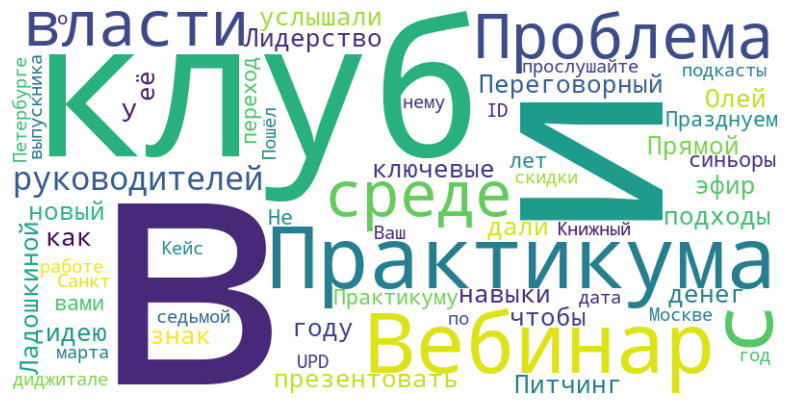

In [90]:
text = ' '.join(df['text_clean'])

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключение осей
plt.show()


**Мы получили токины, играющие подавляющую роль**

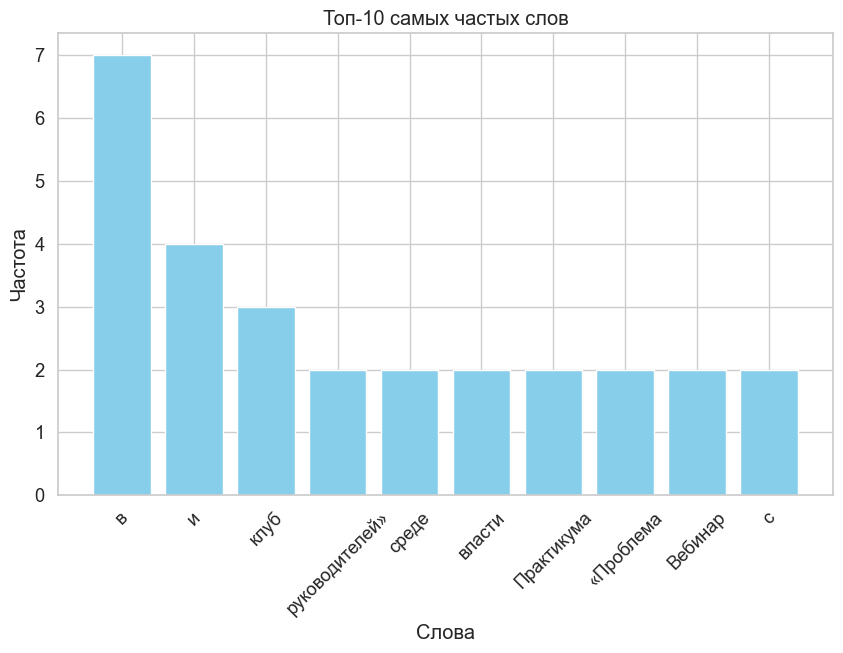

In [91]:
# Разделение текстов на слова и подсчёт частот
all_words = ' '.join(df['text_clean']).split()
word_counts = Counter(all_words)

# Преобразование в DataFrame
word_counts_df = pd.DataFrame(word_counts.items(), columns=['word', 'frequency'])
word_counts_df = word_counts_df.sort_values('frequency', ascending=False)

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(word_counts_df['word'][:10], word_counts_df['frequency'][:10], color='skyblue')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.title('Топ-10 самых частых слов')
plt.xticks(rotation=45)
plt.show()

**Тригерные слова**

### text_entities

In [92]:
# Преобразование строки в список словарей и сохранение результата
df['text_entities'] = df['text_entities'].apply(ast.literal_eval)

# Извлечение значения 'text' из списка словарей
df['text_entities_clean'] = df['text_entities'].apply(lambda x: x[0]['text'] if x else None)

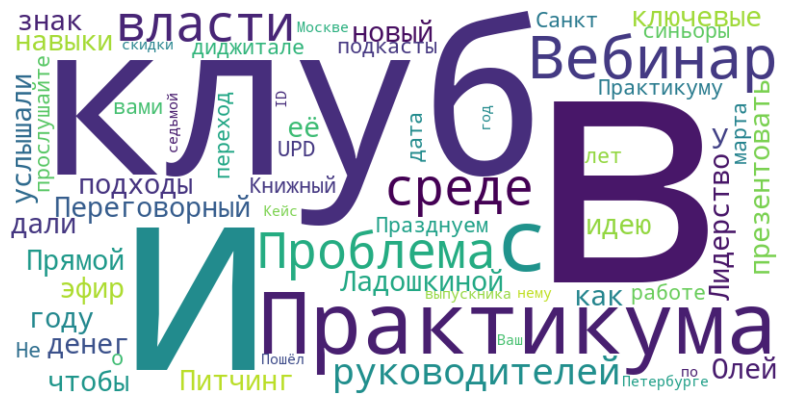

In [93]:
text = ' '.join(df['text_entities_clean'])

# Создание облака слов
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

# Отображение облака слов
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Отключение осей
plt.show()

**Дальше можно не продолжать, сущность полностью повторяет сам text**

### reactions

In [97]:
df['reactions_clean'] = df['reactions'].apply(
    lambda x: {item['emoji']: item['count'] for item in x} if x else None
)

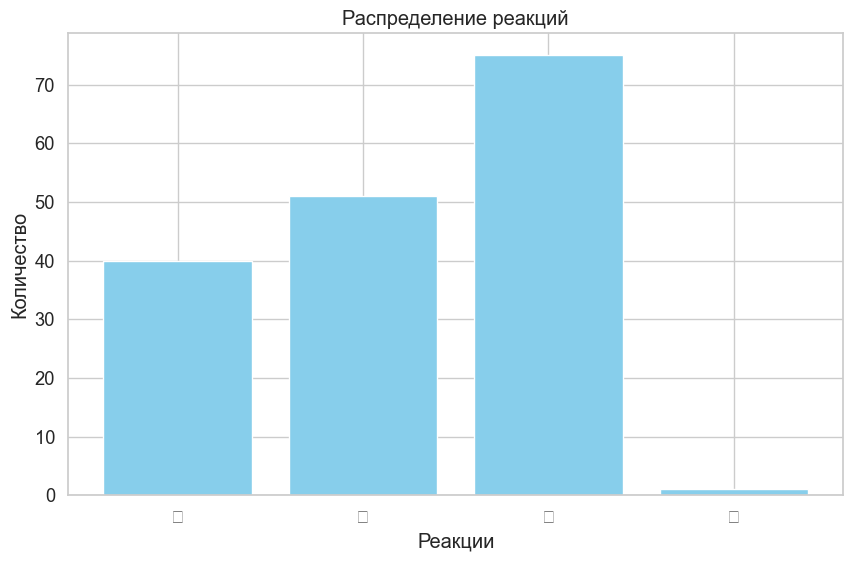

In [98]:
all_reactions = {}
for reactions in df['reactions_clean'].dropna():
    for emoji, count in reactions.items():
        if emoji in all_reactions:
            all_reactions[emoji] += count
        else:
            all_reactions[emoji] = count

# Преобразование в DataFrame
reactions_df = pd.DataFrame(all_reactions.items(), columns=['emoji', 'count'])

# Построение гистограммы
plt.figure(figsize=(10, 6))
plt.bar(reactions_df['emoji'], reactions_df['count'], color='skyblue')
plt.xlabel('Реакции')
plt.ylabel('Количество')
plt.title('Распределение реакций')
plt.show()

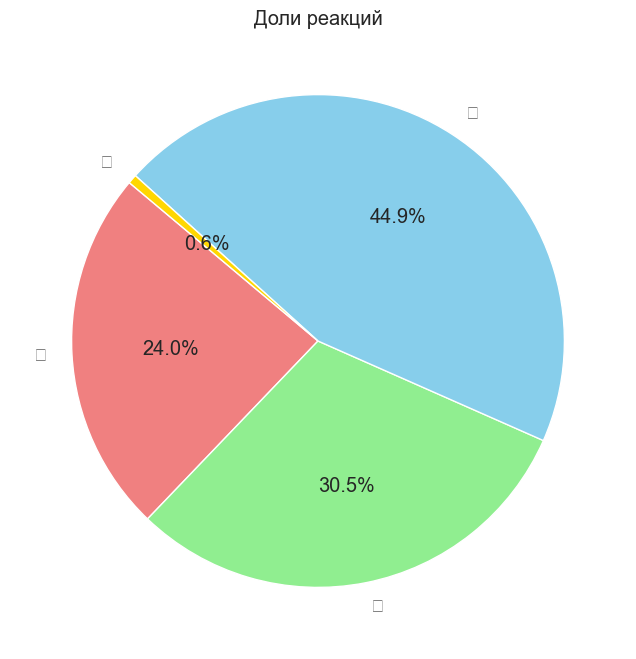

In [99]:
plt.figure(figsize=(8, 8))
plt.pie(reactions_df['count'], labels=reactions_df['emoji'], autopct='%1.1f%%', startangle=140, colors=['lightcoral', 'lightgreen', 'skyblue', 'gold'])
plt.title('Доли реакций')
plt.show()

**Реакции под постами теплые и активные**